# **Preprocessing**

In [1]:
import pandas as pd
import numpy as np
import re
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Read in data from a CSV file
data = pd.read_csv("filtered_paranmt/filtered.tsv", sep="\t", index_col=0)
data.head(7)

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
5,I'm not gonna have a child... ...with the same...,I'm not going to breed kids with a genetic dis...,0.703185,0.206522,0.950956,0.035846
6,"They're all laughing at us, so we'll kick your...",they're laughing at us. We'll show you.,0.618866,0.230769,0.999492,0.000131


C:\Users\84907\AppData\Local\Temp\ipykernel_22876\2379138087.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['ref_tox'])
C:\Users\84907\AppData\Local\Temp\ipykernel_22876\2379138087.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['trn_tox'])


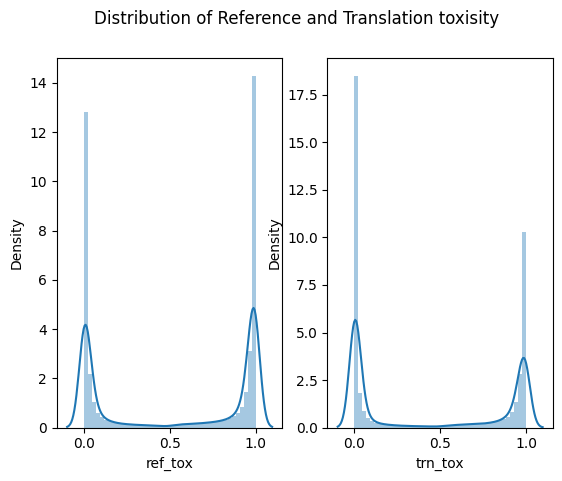

In [5]:
## Visualizing distribution of Reference and Translation
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()

plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.distplot(data['ref_tox'])

plt.subplot(1, 2, 2)
sns.distplot(data['trn_tox'])

plt.suptitle('Distribution of Reference and Translation toxisity')
plt.show()

In [6]:
import string 

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text: str) -> str:
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [7]:
def create_inputs(dataset):
    toxic_set = []
    neutral_set = []
    tox_scores = []
    for ref, trn, ref_score, trn_score in zip(dataset['reference'], dataset['translation'], dataset['ref_tox'], dataset['trn_tox']):
        if ref_score > 0.6 and trn_score < 0.4:
            tox_scores.append(ref_score)
            toxic_set.append(ref)
            neutral_set.append(trn)
        if ref_score < 0.4 and trn_score > 0.6:
            tox_scores.append(trn_score)
            toxic_set.append(trn)
            neutral_set.append(ref)
    
    toxic_set = [text.lower() for text in toxic_set]
    toxic_set = [remove_punctuation(text) for text in toxic_set]

    neutral_set = [text.lower() for text in neutral_set]
    neutral_set = [remove_punctuation(text) for text in neutral_set]
    return toxic_set, neutral_set, tox_scores

In [8]:
toxic_set, neutral_set, tox_scores = create_inputs(data)

In [9]:
input_data = pd.DataFrame(list(zip(toxic_set, neutral_set, tox_scores)), columns=['Toxic', 'Neutral', 'Tox score'])
input_data.head()

,Toxic,Neutral,Tox score
0,if alkar floods her with her mental waste it w...,if alkar is flooding her with psychic waste th...,0.981983
1,youre becoming disgusting,now youre getting nasty,0.999039
2,well we can spare your life,well we could spare your life for one,0.985068
3,monkey you have to wake up,ah monkey youve got to snap out of it,0.994215
4,i have orders to kill her,ive got orders to put her down,0.999348


In [10]:
pd.DataFrame.to_csv(input_data, "filtered_for_models.csv")

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\84907\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

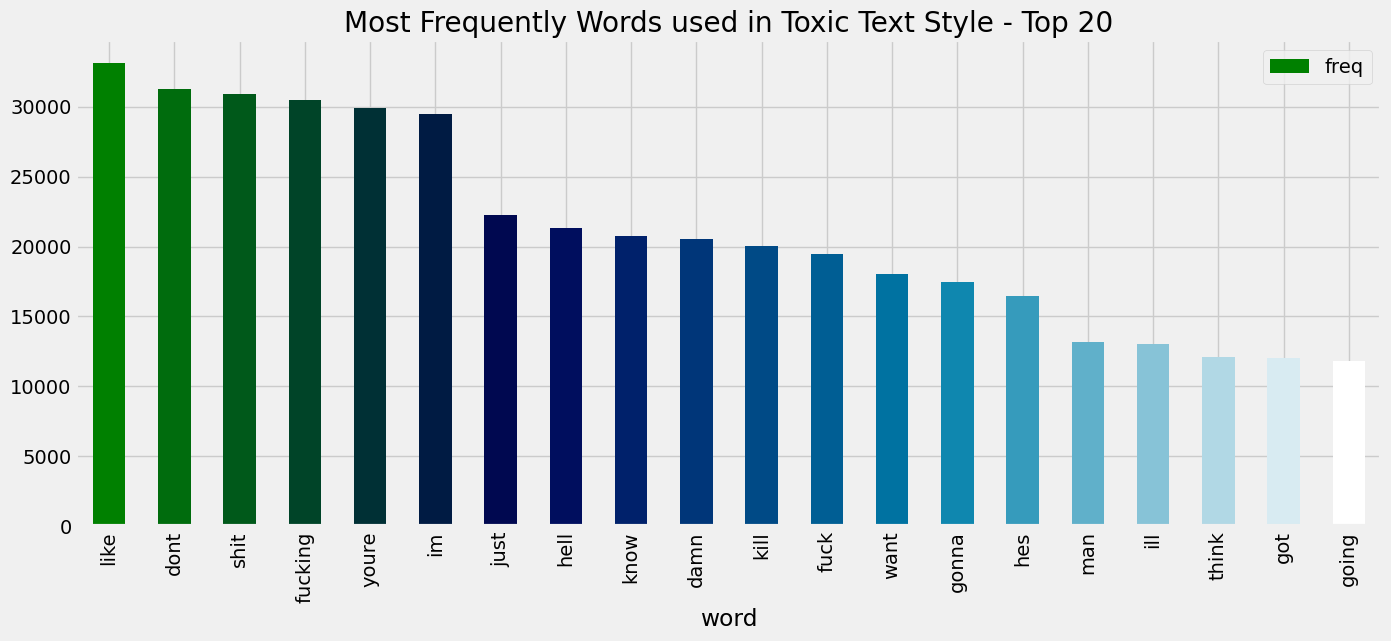

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(input_data['Toxic'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Words used in Toxic Text Style - Top 20")
plt.show()

In [ ]:
# %pip install wordcloud

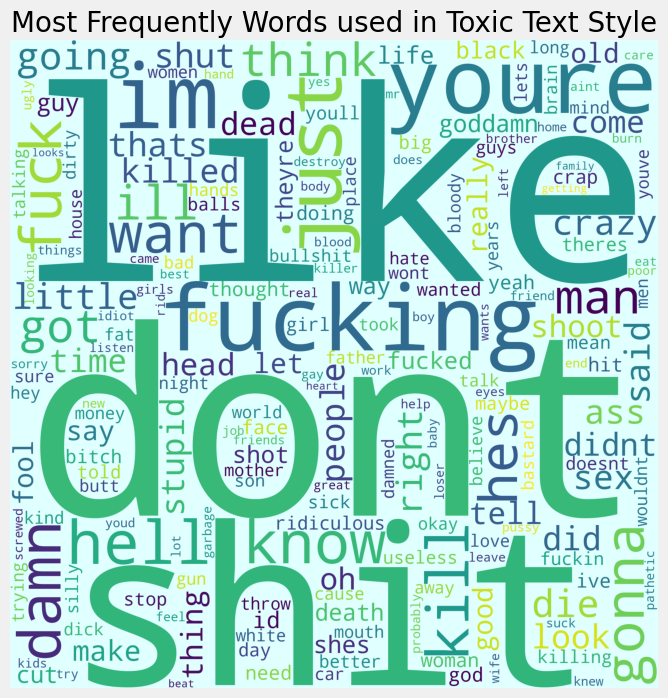

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Most Frequently Words used in Toxic Text Style", fontsize = 20)
plt.show()